In [15]:
import os
import re
import numpy as np
import tensorflow as tf
import sys
base_dir = "C:/Users/Asus/Desktop/SeniorProject2/keras-facenet/"
sys.path.append(base_dir + '/code/')
from inception_resnet_v1 import *

In [16]:
from tensorflow import keras
model = keras.models.load_model(base_dir + 'facenet_keras.h5')

OSError: SavedModel file does not exist at: C:/Users/Asus/Desktop/SeniorProject2/keras-facenet/facenet_keras.h5/{saved_model.pbtxt|saved_model.pb}

In [17]:
model = InceptionResNetV1(classes=512)

In [18]:
model.load_weights("C:/Users/Asus/Desktop/SeniorProject2/keras-facenet/model/keras/weights/facenet_keras_weights.h5")

In [19]:
model.predict

<bound method Model.predict of <tensorflow.python.keras.engine.functional.Functional object at 0x0000022BBDD10AF0>>

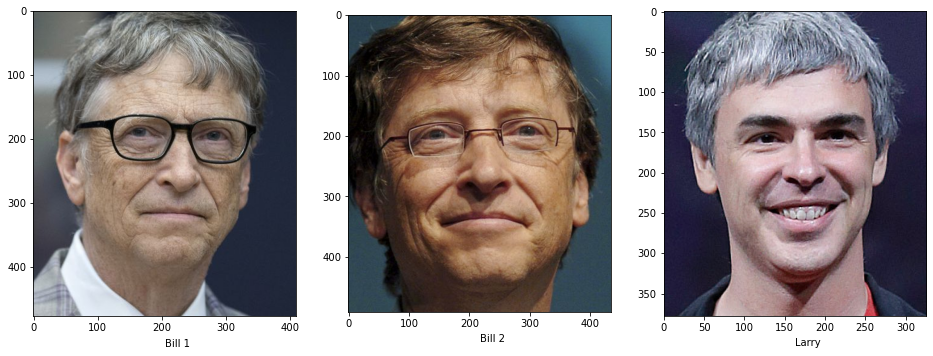

In [20]:
import cv2
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN

def read_image(file):
  img = cv2.imread(file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img

def crop_bb(image, detection, margin):
    x1, y1, w, h = detection['box']
    x1 -= margin
    y1 -= margin
    w += 2*margin
    h += 2*margin
    if x1 < 0:
        w += x1
        x1 = 0
    if y1 < 0:
        h += y1
        y1 = 0
    return image[y1:y1+h, x1:x1+w]

def crop(mtcnn, img):
  det = mtcnn.detect_faces(img)[0]
  margin = int(0.1 * img.shape[0])
  ret = crop_bb(img, det, margin)
  return ret

base_dir = "C:/Users/Asus/Desktop/SeniorProject2/keras-facenet/data/images"

bill1 = read_image(base_dir + "/BillGates/Bill_Gates_0001.jpg")
bill2 = read_image(base_dir + "/BillGates/Bill_Gates_0002.jpg")
larry = read_image(base_dir + "/LarryPage/Larry_Page_0001.jpg")

#crops the faces
mtcnn = MTCNN()
bill1 = crop(mtcnn, bill1)
bill2 = crop(mtcnn, bill2)
larry = crop(mtcnn, larry)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(16, 8)
ax1.imshow(bill1)
ax1.text(0.5,-0.1,"Bill 1", transform=ax1.transAxes)
ax2.imshow(bill2)
ax1.text(0.5,-0.1,"Bill 2", transform=ax2.transAxes)
ax3.imshow(larry)
ax1.text(0.5,-0.1,"Larry", transform=ax3.transAxes)

plt.show()

In [21]:
def pre_process(face, required_size=(160, 160)):

    ret = cv2.resize(face, required_size)
    #ret = cv2.cvtColor(ret, cv2.COLOR_BGR2RGB)
    ret = ret.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = ret.mean(), ret.std()
    ret = (ret - mean) / std

    return ret

In [22]:
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [23]:
imgs = [bill1, bill2, larry]
samples = [pre_process(i) for i in imgs]

In [39]:
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


In [42]:
outputs = []
dictionary = {}
dictionary = dict()
i = 0
for sample in samples:
    i = i+1
    sample = np.expand_dims(sample, axis= 0)
    predicted_vector = model.predict(sample)
    outputs.append(predicted_vector)
    pair = {'a' + str(i): predicted_vector}
    dictionary.update(pair)
ret = np.stack(outputs)


In [43]:
import json
json.dumps(dictionary, cls=NumpyEncoder)

'{"a1": [[0.05758705362677574, 0.019009511917829514, 0.03275278955698013, -0.0034122623037546873, -0.034105949103832245, 0.024788210168480873, -0.026574311777949333, -0.050154007971286774, 0.007261545863002539, -0.036410585045814514, -0.02264513447880745, 0.02061840519309044, -0.07793276757001877, -0.04599584639072418, 0.008023682981729507, -0.005813851952552795, 0.03071093186736107, 0.02497950568795204, 0.009573638439178467, -0.02402389608323574, -0.05029476061463356, 0.010816759429872036, -0.05609988793730736, 0.021412931382656097, -0.021004918962717056, 0.03074859268963337, -0.06178406625986099, 0.050044670701026917, -0.05856996029615402, -0.029516125097870827, -0.013202597387135029, 0.028338870033621788, -0.03438001126050949, -0.0030976305715739727, -0.0022396391723304987, -0.04503997042775154, -0.047871142625808716, -0.054137200117111206, -0.030236708000302315, 0.017082717269659042, 0.08839328587055206, -0.03095235303044319, -0.029586441814899445, 0.054968368262052536, -0.01375052

In [26]:
import json


TypeError: Object of type ndarray is not JSON serializable

In [25]:
dist = np.linalg.norm(ret[0, :] - ret[1, :])
dist

0.90827453